<a href="https://colab.research.google.com/github/daniel-luper/pixel-art-dcgan/blob/main/Edited_DataminingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

Dataset
https://huggingface.co/datasets/jiovine/pixel-art-nouns-2k

In [ ]:
!pip install pyarrow
!pip install tensorflow
!pip install Pillow

In [ ]:
import pyarrow.parquet as pq
import tensorflow as tf

import glob
import random
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from tqdm import tqdm
from tensorflow.keras import layers
import time

from IPython import display

from PIL import Image
import io

import shutil
import glob

# (Optional) Clear Environement

In [ ]:
# Clear the models
generator = None
discriminator = None

# Function to delete files with a specific extension
def delete_files(extension):
    files = glob.glob(f'*.{extension}')
    for file in files:
        try:
            os.remove(file)
            print(f"Deleted {file}")
        except OSError as e:
            print(f"Error: {file} : {e.strerror}")

# Delete all PNG files
delete_files('png')

# Delete all GIF files
delete_files('gif')

# Function to recursively delete a directory
def delete_directory(directory):
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            print(f"Deleted {directory} directory and all of its contents")
        except OSError as e:
            print(f"Error: {directory} : {e.strerror}")
    else:
        print(f"The directory {directory} does not exist.")

# Recursively delete the 'training_checkpoints' folder
delete_directory('training_checkpoints')

print("All specified files and directories have been deleted.")



The directory training_checkpoints does not exist.
All specified files and directories have been deleted.


# Training

### Hyperparameters

In [ ]:
DISC_ALPHA = 1e-4
DISC_BETA1 = 0.3
GEN_ALPHA  = 1e-4
GEN_BETA1  = 0.3
BATCH_SIZE = 40

def display_hyperparameters():
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'Discriminator Optimizer: Adam (alpha={DISC_ALPHA}, beta_1={DISC_BETA1})')
    print(f'Generator Optimizer: Adam (alpha={GEN_ALPHA}, beta_1={GEN_BETA1})')

### Load Dataset

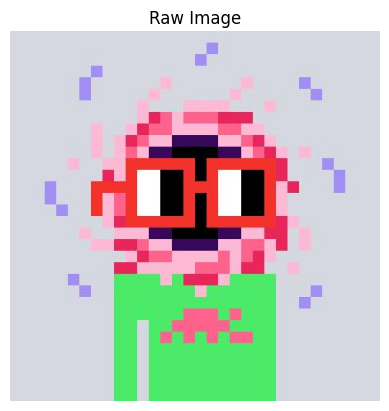

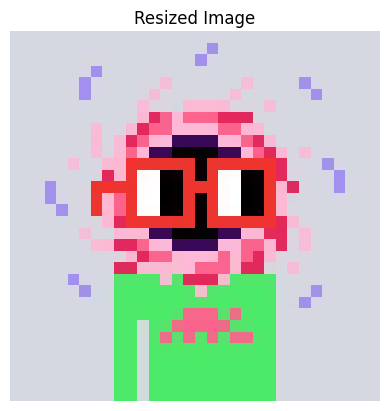

In [ ]:
# Read the image data from the file and store it in a dataframe
df = pq.read_table('data.parquet', columns=['image']).to_pandas()

img_dim = (32,32)
raw_images = []
train_images = []

# For each image
for row in df.itertuples():
  # Extract the binary data for the image
  binary_data = (row.image)['bytes']
  # Open the data as an image and convert it to RGB
  image = Image.open(io.BytesIO(binary_data)).convert('RGB')
  # Add it to the raw images array
  raw_images.append(np.array(image))
  # Downsize it from 320x320 back to the original 32x32
  image = image.resize(img_dim, Image.BOX)
  # Add it to the image array
  train_images.append(np.array(image))

sample_idx = 7

# Display a raw image
plt.figure()
plt.imshow(raw_images[sample_idx])
plt.title('Raw Image')
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Display a resized image
plt.figure()
plt.imshow(train_images[sample_idx])
plt.title('Resized Image')
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Convert the list to an nparray
train_images = np.array(train_images)

# Note: train_images is a numpy ndarray of dim (2000, 32, 32, 3).
# Each RGB pixel value is normalized to values between -1 and 1.


### Pre-processing

mean: 10.263
std dev: 2.3769373151179227
min/max: 5/21


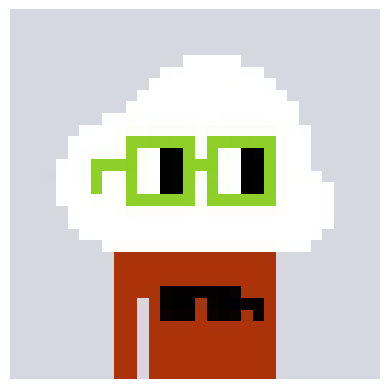

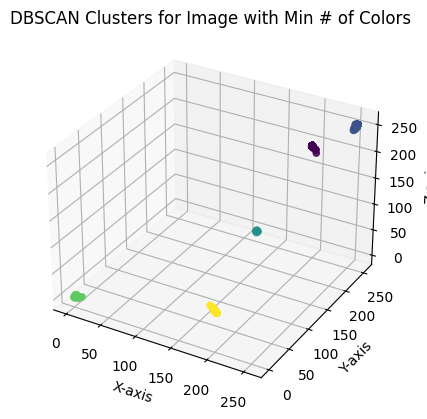

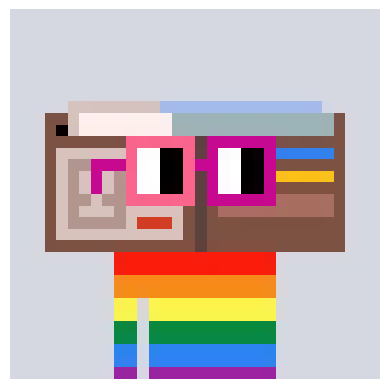

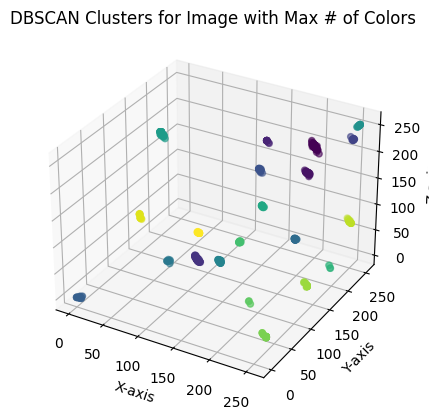

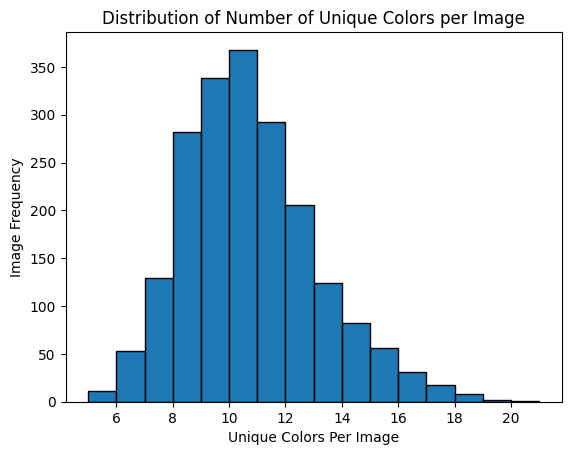

In [ ]:
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

flattened_images = train_images.reshape(2000, -1, 3) # dim: (2000,1024,3)
color_counts = [0 for x in range(2000)]
all_clusters = [] # each element is the set of color/point clusters for the ith image
all_centroid_mappings = [] # the unique labels and centroids for each image

for i, img in enumerate(flattened_images):
  # Perform DBSCAN to find the colors in the images
  dbscan = DBSCAN(eps=9, min_samples=1)
  clusters = dbscan.fit_predict(img)
  all_clusters.append(clusters)

  # Get the cluster labels
  labels = dbscan.labels_

  # Count the number of unique labels, excluding noise (-1)
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

  # Get unique labels (excluding noise points with label -1)
  unique_labels = set(labels) - {-1}

  color_counts[i] = n_clusters

  # Calculate centroids for each cluster
  centroids = []
  for label in unique_labels:
      cluster_points = img[labels == label]
      centroid = cluster_points[np.linalg.norm(cluster_points - np.mean(cluster_points, axis=0), axis=1).argmin()]
      centroids.append(centroid)
  # Map the labels to the centroids (colors)
  mapping = {list(unique_labels)[i]: centroids[i] for i in range(len(unique_labels))}
  all_centroid_mappings.append(mapping)



cc = np.asarray(color_counts)
print(f'mean: {np.mean(cc)}')
print(f'std dev: {np.std(cc)}')
min = np.min(cc)
max = np.max(cc)
print(f'min/max: {min}/{max}')
minndx = np.argmin(cc)
maxndx = np.argmax(cc)
minimg = train_images[minndx]
maximg = train_images[maxndx]

def displayImage(img):
  plt.figure()
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()

def displayClusters(img, clusters, title):
  # Creating a 3D scatter plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot for each cluster
  scatter = ax.scatter(img[:, 0], img[:, 1], img[:, 2], c=clusters, cmap='viridis')

  # Adding labels and title
  ax.set_title(title)
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Z-axis')

  # Show plot
  plt.show()

displayImage(minimg)
displayClusters(flattened_images[minndx], all_clusters[minndx], 'DBSCAN Clusters for Image with Min # of Colors')
displayImage(maximg)
displayClusters(flattened_images[maxndx], all_clusters[maxndx], 'DBSCAN Clusters for Image with Max # of Colors')

# Plot the histogram
bins = np.arange(min, max + 1)  # +1 to include the last value
plt.hist(cc, bins, edgecolor='black')
plt.title('Distribution of Number of Unique Colors per Image')
plt.xlabel('Unique Colors Per Image')
plt.ylabel('Image Frequency')
plt.show()

In [ ]:
# The set of train images with true colors
train_images_true_color = []

# for each image, get it's cluster labels
for i, img in enumerate(all_clusters):
  # the new image to be produced
  new_img = []
  # retrieve the mapping
  mapping = all_centroid_mappings[i]
  # for each pixel in the image
  for label in img:
    # replace the old color with the true color
    new_img.append(mapping.get(label))
  # reshape the image and add it
  new_img = np.array(new_img).reshape((32, 32, 3))
  train_images_true_color.append(new_img)

train_images_true_color = np.array(train_images_true_color)

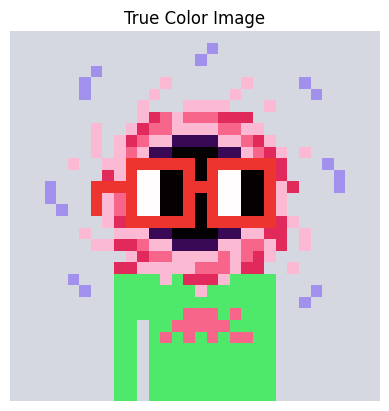

In [ ]:
# Display true color image
plt.imshow(train_images_true_color[sample_idx])
plt.title('True Color Image')
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
# Converts values from uint8 to float32 (basically from int to float)
train_images_true_color = train_images_true_color.reshape(train_images.shape[0], img_dim[0], img_dim[1], 3).astype('float32')
# Converts values to be between -1 and 1
train_images_true_color = (train_images_true_color - 127.5) / 127.5  # Normalize the images to [-1, 1]


### Batching and Shuffling

In [ ]:
BUFFER_SIZE = 2000

# Batch and shuffle the data, then prefetch and optionally cache
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_true_color)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Prefetch the next batch while the current batch is being used to train the model
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# If the dataset fits in memory, you can cache it
# We're caching after shuffling to get a fresh shuffle each
train_dataset = train_dataset.cache()

### Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    # Start with a Dense layer that will be reshaped into a 8x8 128-channel feature map
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128)  # None is the batch size

    # First Conv2DTranspose layer to upscale to 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second Conv2DTranspose layer to upscale to 32x32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final Conv2DTranspose layer to produce the output image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))  # Use 'tanh' for output in [-1, 1]
    assert model.output_shape == (None, 32, 32, 3)

    return model


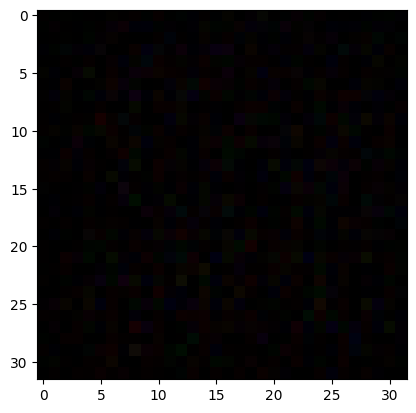

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
#print(noise)
generated_image = generator(noise, training=False)

#print(generated_image[0])
plt.imshow(generated_image[0,:,:,:])

Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Input shape is now 32x32.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Strides remain the same; we will get a 16x16 output here.
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Here we'll get an 8x8 output, which is reasonable for a 32x32 input.
    # If you wanted to add an additional Conv2D layer, you could,
    # but it might not be necessary for such small images.

    # Flatten the output of the last convolutional layer
    model.add(layers.Flatten())
    # Add a Dense layer with a single output for binary classification (real or fake)
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.build()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

Loss functions

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(GEN_ALPHA, beta_1=GEN_BETA1)
discriminator_optimizer = tf.keras.optimizers.Adam(DISC_ALPHA, beta_1=DISC_BETA1)

### Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training loop

In [ ]:
DISPLAY_EPOCHS = 50 # record the latest generated image every DISPLAY_EPOCHS
GIF_DURATION = 800 # ms between each frame
checkpoint_saves = 100 # how often to save a checkpoint
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss

def save_model_checkpoint(epoch):
    if (epoch + 1) % checkpoint_saves == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

def calculate_avg_discriminator_loss(total_disc_loss, dataset):
    return total_disc_loss / len(dataset)

def plot_discriminator_performance(epochs, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), discriminator_losses, label="Discriminator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Discriminator Performance Over Epochs')
    plt.legend()
    plt.show()

def create_gif(image_paths):
    images = [Image.open(image) for image in image_paths]
    images[0].save('generated_images.gif',
                   save_all=True,
                   append_images=images[1:],
                   optimize=False, duration=GIF_DURATION, loop=0)
    display.Image(filename="generated_images.gif")

def display_network_parameters():
    generator_params = np.sum([np.prod(v.get_shape()) for v in generator.trainable_variables])
    discriminator_params = np.sum([np.prod(v.get_shape()) for v in discriminator.trainable_variables])
    print(f'Number of parameters in generator: {generator_params}')
    print(f'Number of parameters in discriminator: {discriminator_params}')

def train(dataset, epochs):
    start = time.time()
    discriminator_losses = []
    image_paths = []

    for epoch in tqdm(range(epochs), desc='Training Progress', unit='epoch'):
        start_epoch = time.time()
        total_disc_loss = 0

        for image_batch in dataset:
            disc_loss = train_step(image_batch)
            total_disc_loss += disc_loss

        avg_disc_loss = calculate_avg_discriminator_loss(total_disc_loss, dataset)
        discriminator_losses.append(avg_disc_loss)

        if epoch % DISPLAY_EPOCHS == 0:
            image_path = f'generated_img_epoch_{epoch}.png'
            generate_and_save_images(generator, epoch, seed, image_path)
            image_paths.append(image_path)

        save_model_checkpoint(epoch)

    total_training_time = time.time() - start
    print(f'Total Training Time: {total_training_time} seconds')
    print(f'Average epochs per second: {epochs/total_training_time} epochs/sec')

    image_path = f'generated_img_epoch_{epoch}.png'
    image_paths.append(image_path)
    generate_and_save_images(generator, epochs, seed, image_path)
    create_gif(image_paths)
    plot_discriminator_performance(epochs, discriminator_losses)
    display_network_parameters()
    display_hyperparameters()
    print(f'Epochs: {epochs}')

def generate_and_save_images(model, epoch, test_input, image_path, debug=False):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  # Normalize the prediction to [0,1]
  img = (predictions + 1) / 2

  fig = plt.figure(figsize=(8, 8))
  for i in range(img.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i, :, :, :], interpolation='nearest')
    plt.axis('off')

  plt.savefig(image_path)

  if debug:
    plt.show()
  else:
    plt.clf()
    plt.close(fig)


Training Progress: 100%|██████████| 2000/2000 [25:19<00:00,  1.32epoch/s]


Total Training Time: 1519.5872893333435 seconds
Average epochs per second: 1.3161468341035005 epochs/sec


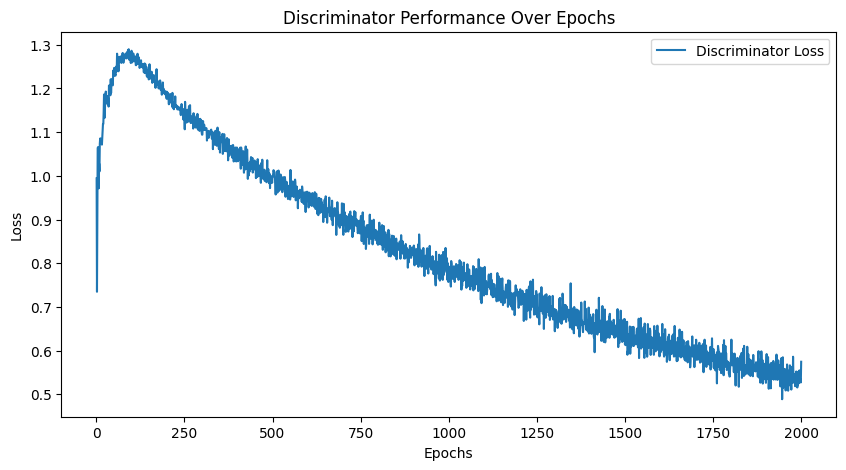

Number of parameters in generator: 1455168
Number of parameters in discriminator: 217985
Batch Size: 40
Discriminator Optimizer: Adam (alpha=0.0001, beta_1=0.3)
Generator Optimizer: Adam (alpha=0.0001, beta_1=0.3)
Epochs: 2000


In [ ]:
EPOCHS = 2000
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_dataset, EPOCHS)

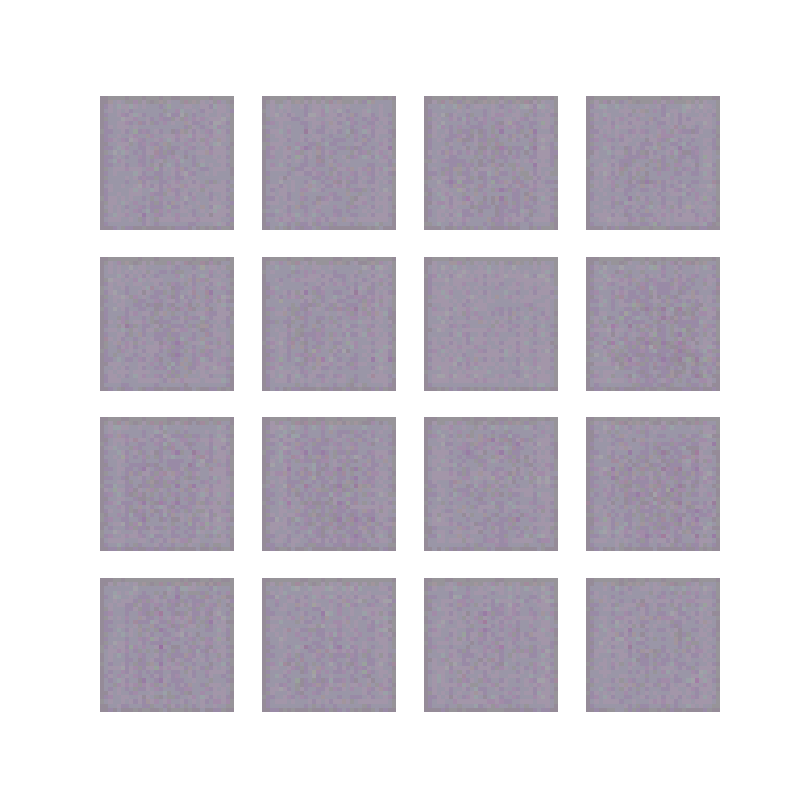

In [ ]:
# Display the gif of generation progress
display.Image(filename="generated_images.gif")

# Image Generation

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
print(checkpoint.restore(latest))

./training_checkpoints/ckpt-20


In [ ]:
seed = tf.random.normal([64, 100])
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(12, 12))

imgs = (predictions + 1) / 2

for i, color_image in enumerate(imgs):
    plt.subplot(8, 8, i+1)
    plt.imshow(color_image, interpolation='nearest')
    plt.axis('off')

plt.show()



# brightness_threshold = 0.90 # 90 %

# for i, color_image in enumerate(predictions):
#     # Convert to grayscale using luminance formula
#     grayscale_image = 0.2989 * color_image[:, :, 0] + 0.5870 * color_image[:, :, 1] + 0.1140 * color_image[:, :, 2]

#     print(grayscale_image.shape)

#     # Count bright pixels
#     bright_pixels = np.sum(grayscale_image >= brightness_threshold)
#     total_pixels = grayscale_image.numpy().size
#     bright_percentage = (bright_pixels / total_pixels) * 100

#     print(f"Image {i+1}: {bright_percentage:.2f}% pixels are >= {brightness_threshold * 100}% brightness")

#     plt.subplot(4, 4, i+1)
#     plt.imshow(color_image, interpolation='nearest')
#     plt.axis('off')

# plt.show()



NameError: ignored